In [7]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import findspark
import pyspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
from pyspark.sql.functions import col, count, isnan, mean as _mean
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import log1p, col
spark = SparkSession.builder.appName("Iterate prior steps").getOrCreate()


file = "final_df.csv" 


Iterate_p = spark.read.csv(file, header=True, inferSchema=True)
Iterate_p.show()

min_ceii = Iterate_p.select("CEII").rdd.min()[0]
max_ceii = Iterate_p.select("CEII").rdd.max()[0]
bins = list(np.arange(min_ceii, max_ceii + 0.5, 0.5))

bucketizer = Bucketizer(splits=bins, inputCol="CEII", outputCol="CEII_binned")
a = bucketizer.setHandleInvalid("keep").transform(Iterate_p)

bin_counts = a.groupBy("CEII_binned").count().orderBy("CEII_binned")
selected_columns = [
    'clonesize', 'honeybee',  'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
     'yield','CEII_binned']
I_new = a.select(selected_columns)

I_new.show(5)





+---------+--------+--------------------+--------------------+-----------+------------------+-----------+-----------+-----------+-----------+--------------------+
|clonesize|honeybee|AverageOfUpperTRange|AverageOfLowerTRange|RainingDays|AverageRainingDays|   fruitset|  fruitmass|      seeds|      yield|                CEII|
+---------+--------+--------------------+--------------------+-----------+------------------+-----------+-----------+-----------+-----------+--------------------+
|     37.5|    0.75|                71.9|                50.8|       16.0|              0.26|0.410652063|0.408159008|31.67889844|3813.165795|  0.8868889659115409|
|     37.5|    0.75|                71.9|                50.8|        1.0|               0.1|0.444254359|0.425457642|33.44938499|4947.605663|  0.5775908672389378|
|     37.5|    0.75|                79.0|                55.9|       16.0|              0.26|0.383786508|0.399172403|30.54630597|3866.798965|  1.3537163305393505|
|     37.5|    0.75|  

In [19]:
# The linear regression model

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, lit
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("Linear Regression Analysis").getOrCreate()



# Prepare features and labels
feature_columns = [c for c in I_new.columns if c != 'yield']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(I_new).select(col("features"), col("yield").alias("label"))

# Split the data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Initialize and train the Linear Regression model
lr = LinearRegression(featuresCol="features", labelCol="label",regParam=0.3, elasticNetParam=0.8)
model = lr.fit(train_data)

# Predictions on test and training data
train_predictions = model.transform(train_data)
test_predictions = model.transform(test_data)

# Evaluate the model with RMSE
evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
train_rmse = evaluator.evaluate(train_predictions)
test_rmse = evaluator.evaluate(test_predictions)
from pyspark.sql.functions import mean, min, max, abs as abs_
from pyspark.mllib.stat import Statistics

# Function to calculate metrics from predictions DataFrame
def calculate_metrics(predictions):
    predictions = predictions.withColumn("Error", col("label") - col("prediction"))
    min_error = predictions.select(min(abs_("Error")).alias("min_error")).collect()[0]['min_error']
    max_error = predictions.select(max(abs_("Error")).alias("max_error")).collect()[0]['max_error']
    mean_error = predictions.select(mean("Error").alias("mean_error")).collect()[0]['mean_error']
    mae = predictions.select(mean(abs_("Error")).alias("mae")).collect()[0]['mae']
    # Pearson correlation requires rdd, calculate it on label vs prediction
    correlation = Statistics.corr(predictions.select("label").rdd.map(lambda x: x[0]), 
                                  predictions.select("prediction").rdd.map(lambda x: x[0]), 
                                  method="pearson")
    return min_error, max_error, mean_error, mae, correlation

# Calculate metrics for training and testing data
train_metrics = calculate_metrics(train_predictions)
test_metrics = calculate_metrics(test_predictions)

# Print out the results for training data
print("Training Data Metrics:")
print(f"Minimum Error: {train_metrics[0]}")
print(f"Maximum Error: {train_metrics[1]}")
print(f"Mean Error: {train_metrics[2]}")
print(f"Mean Absolute Error (MAE): {train_metrics[3]}")
print(f"Pearson Correlation Coefficient: {train_metrics[4]}")

# Print out the results for testing data
print("\nTesting Data Metrics:")
print(f"Minimum Error: {test_metrics[0]}")
print(f"Maximum Error: {test_metrics[1]}")
print(f"Mean Error: {test_metrics[2]}")
print(f"Mean Absolute Error (MAE): {test_metrics[3]}")
print(f"Pearson Correlation Coefficient: {test_metrics[4]}")

# Print evaluation metrics
print("Training Data RMSE: {:.3f}".format(train_rmse))
print("Testing Data RMSE: {:.3f}".format(test_rmse))

# Calculate residuals
train_predictions = train_predictions.withColumn("residuals", col("prediction") - col("label"))
test_predictions = test_predictions.withColumn("residuals", col("prediction") - col("label"))

# Plot residuals
train_residuals = train_predictions.select("prediction", "residuals").collect()
test_residuals = test_predictions.select("prediction", "residuals").collect()





coefficients = model.coefficients  # This gets the coefficients of the features
feature_names = feature_columns   # This should match the features inputted to the model

# Associate coefficients with feature names
feature_importance = [(feature, abs(coef)) for feature, coef in zip(feature_names, coefficients)]

# Sort features by importance
feature_importance_sorted = sorted(feature_importance, key=lambda x: x[1], reverse=True)

# Unzip for plotting
features, importances = zip(*feature_importance_sorted)

24/05/19 06:11:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/19 06:11:29 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Training Data Metrics:
Minimum Error: 0.3032289759694322
Maximum Error: 790.1675645423884
Mean Error: -4.507082473104435e-12
Mean Absolute Error (MAE): 115.21472670870659
Pearson Correlation Coefficient: 0.9939007490294091

Testing Data Metrics:
Minimum Error: 0.23198002324079425
Maximum Error: 524.4120402174203
Mean Error: 12.701564635550309
Mean Absolute Error (MAE): 117.30214638167769
Pearson Correlation Coefficient: 0.9924988137676223
Training Data RMSE: 151.801
Testing Data RMSE: 154.662


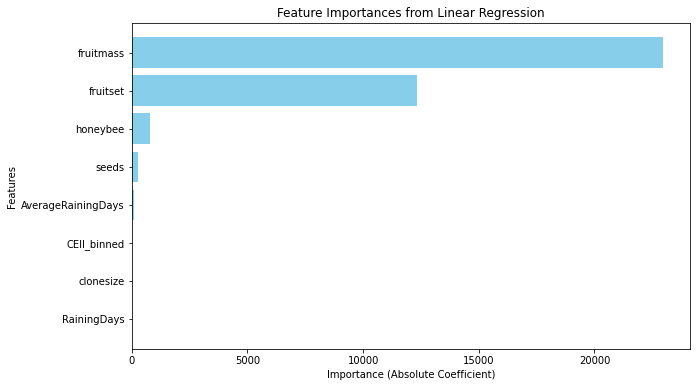

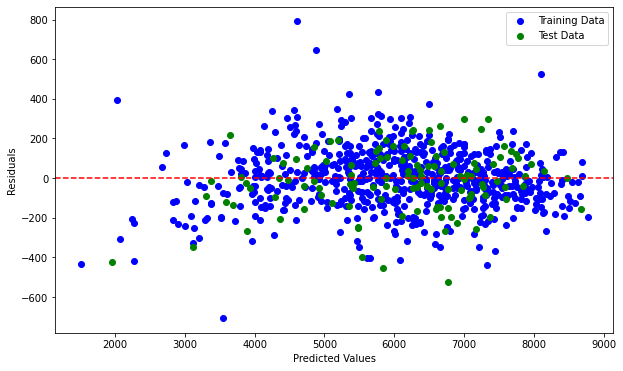

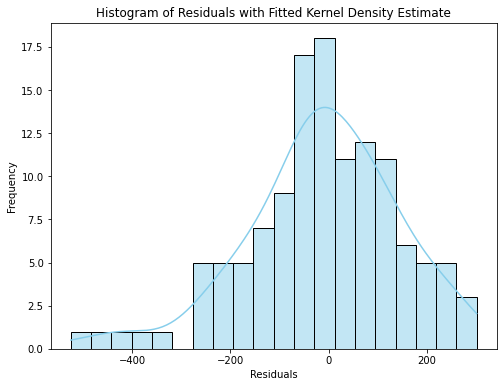

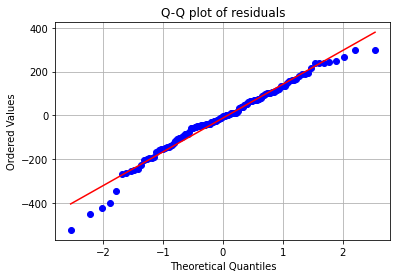

In [20]:
import matplotlib.pyplot as plt
from scipy import stats

# Plotting feature importances
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance (Absolute Coefficient)')
plt.ylabel('Features')
plt.title('Feature Importances from Linear Regression')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter([x['prediction'] for x in train_residuals], [x['residuals'] for x in train_residuals], color='blue', label='Training Data')
plt.scatter([x['prediction'] for x in test_residuals], [x['residuals'] for x in test_residuals], color='green', label='Test Data')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Collect data and plot histogram of residuals using seaborn
all_residuals = [x['residuals'] for x in test_residuals]  # combining test residuals
plt.figure(figsize=(8, 6))
sns.histplot(all_residuals, kde=True, color='skyblue', bins=20)
plt.title('Histogram of Residuals with Fitted Kernel Density Estimate')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()



# Assuming 'test_predictions' already has the 'residuals' column calculated
# Collect residuals data for plotting (ensure manageable dataset size)
residuals_list = test_predictions.select("residuals").rdd.flatMap(lambda x: x).collect()

# Generate a Q-Q plot using scipy's probplot
stats.probplot(residuals_list, dist="norm", plot=plt)
plt.title('Q-Q plot of residuals')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Ordered Values')
plt.grid(True)
plt.show()

spark.stop()

In [2]:
# GBT
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col  
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, min, max, mean, abs as abs_
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

spark = SparkSession.builder.appName("GBTRegressor Example").getOrCreate()



feature_columns = [c for c in I_new.columns if c != 'yield']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data = assembler.transform(I_new).select(col("features"), col("yield").alias("label"))

train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

gbt = GBTRegressor(featuresCol="features", labelCol="label", maxIter=100, seed=42)
model = gbt.fit(train_data)

predictions = model.transform(test_data)



NameError: name 'train_predictions' is not defined

Training Data Metrics:
RMSE: 76.83810332317228
MAE: 51.8532570795449
Minimum Error: 0.29235390530539007
Maximum Error: 485.85611359382256
Mean Error: 7.395737927127486e-13
Pearson Correlation Coefficient: 0.9984407703611818

Testing Data Metrics:
RMSE: 188.15376749312742
MAE: 145.32512042856325
Minimum Error: 0.8236480101418238
Maximum Error: 706.2346918815224
Mean Error: 2.368372887436617
Pearson Correlation Coefficient: 0.9884706133030194
Feature Importances:
fruitset: 0.774013730680078
seeds: 0.1259058602293822
fruitmass: 0.03007846186884941
CEII_binned: 0.029901700208693656
clonesize: 0.014616384047661095
honeybee: 0.012745171989087046
RainingDays: 0.012609326470167046
AverageRainingDays: 0.0001293645060817859


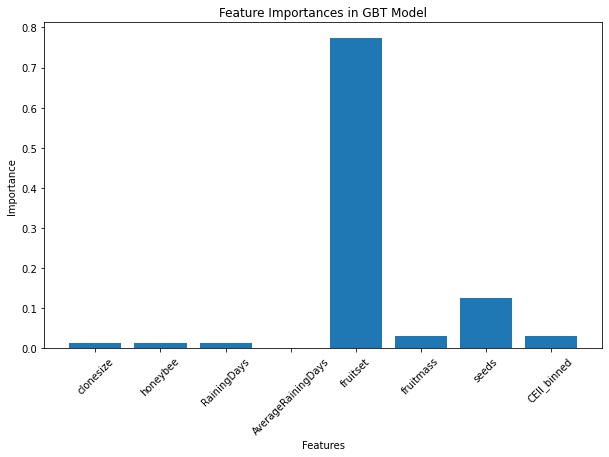

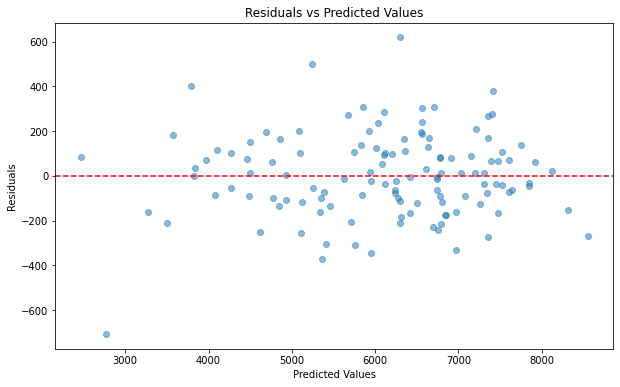

In [6]:
train_predictions = model.transform(train_data)
test_predictions = model.transform(test_data)

train_predictions = train_predictions.withColumn("Error", col("prediction") - col("label"))
test_predictions = test_predictions.withColumn("Error", col("prediction") - col("label"))

evaluator = RegressionEvaluator(labelCol="label", predictionCol="prediction")
train_rmse = evaluator.evaluate(train_predictions, {evaluator.metricName: "rmse"})
test_rmse = evaluator.evaluate(test_predictions, {evaluator.metricName: "rmse"})
train_mae = evaluator.evaluate(train_predictions, {evaluator.metricName: "mae"})
test_mae = evaluator.evaluate(test_predictions, {evaluator.metricName: "mae"})


xtrain_correlation = train_predictions.stat.corr("label", "prediction")
test_correlation = test_predictions.stat.corr("label", "prediction")

train_min_error = train_predictions.select(min(abs_("Error")).alias("min_error")).collect()[0]["min_error"]
train_max_error = train_predictions.select(max(abs_("Error")).alias("max_error")).collect()[0]["max_error"]
train_mean_error = train_predictions.select(mean("Error").alias("mean_error")).collect()[0]["mean_error"]

test_min_error = test_predictions.select(min(abs_("Error")).alias("min_error")).collect()[0]["min_error"]
test_max_error = test_predictions.select(max(abs_("Error")).alias("max_error")).collect()[0]["max_error"]
test_mean_error = test_predictions.select(mean("Error").alias("mean_error")).collect()[0]["mean_error"]

print("Training Data Metrics:")
print(f"RMSE: {train_rmse}")
print(f"MAE: {train_mae}")
print(f"Minimum Error: {train_min_error}")
print(f"Maximum Error: {train_max_error}")
print(f"Mean Error: {train_mean_error}")
print(f"Pearson Correlation Coefficient: {train_correlation}")

print("\nTesting Data Metrics:")
print(f"RMSE: {test_rmse}")
print(f"MAE: {test_mae}")
print(f"Minimum Error: {test_min_error}")
print(f"Maximum Error: {test_max_error}")
print(f"Mean Error: {test_mean_error}")
print(f"Pearson Correlation Coefficient: {test_correlation}")

# get the importance
feature_importances = model.featureImportances.toArray()
features_and_importances = zip(feature_columns, feature_importances)

sorted_features_and_importances = sorted(features_and_importances, key=lambda x: x[1], reverse=True)

print("Feature Importances:")
for feature, importance in sorted_features_and_importances:
    print(f"{feature}: {importance}")
    
    
plt.figure(figsize=(10, 6))
plt.bar(feature_columns, feature_importances)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances in GBT Model')
plt.xticks(rotation=45)
plt.show()


prediction_and_labels = predictions.select("prediction", "label").collect()
preds = [p['prediction'] for p in prediction_and_labels]
labels = [p['label'] for p in prediction_and_labels]
# 计算残差
residuals = [pred - label for pred, label in zip(preds, labels)]

# 绘制残差图
plt.figure(figsize=(10, 6))
plt.scatter(preds, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()